<a href="https://colab.research.google.com/github/LeechXDD/9417_Pro_Project/blob/main/COMP9417.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [1]:
!pip install tensorflow_addons
!pip install tensorflow_decision_forests
!pip install tensorflow
!pip install tensorflow --upgrade
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 37.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: numpy


In [69]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [70]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"benedictachun","key":"a3f94529fc258924b3388f08d1efba16"}'}

In [71]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [72]:
!kaggle competitions download -c predict-student-performance-from-game-play
! kaggle datasets list

predict-student-performance-from-game-play.zip: Skipping, found more recently modified local copy (use --force to force download)
ref                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
alphiree/cardiovascular-diseases-risk-prediction-dataset       Cardiovascular Diseases Risk Prediction Dataset    5MB  2023-07-03 12:12:19           2781        119  1.0              
nelgiriyewithana/countries-of-the-world-2023                   Global Country Information Dataset 2023           23KB  2023-07-08 20:37:33           1719         67  1.0              
arnavsmayan/netflix-userbase-dataset                           Netflix Userbase Dataset                          25KB  2023-07-04 07:3

In [73]:
! mkdir kaggleData
! unzip predict-student-performance-from-game-play.zip -d kaggleData

from google.colab import drive
drive.mount('/content/drive')

mkdir: cannot create directory ‘kaggleData’: File exists
Archive:  predict-student-performance-from-game-play.zip
replace kaggleData/jo_wilder/__init__.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
def get_minimal_dtype(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage became: ",mem_usg," MB")

    return df

In [75]:
dataset_df = pd.read_csv('kaggleData/train.csv')
dataset_df = get_minimal_dtype(dataset_df)

test_data = pd.read_csv('kaggleData/test.csv')

Memory usage of dataframe is 4012.60 MB
Memory usage became:  1028.2593326568604  MB


In [76]:
# Load in labels for training dataset
labels = pd.read_csv('kaggleData/train_labels.csv')
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

### Exploratory Data Analysis

Missing values in dataset

In [77]:
train_missing_value = dataset_df.isnull().sum().reset_index()
train_missing_value.columns = ['column_name', 'train data missing_count']
train_missing_value

,column_name,train data missing_count
0,session_id,0
1,index,0
2,elapsed_time,0
3,event_name,0
4,name,0
5,level,0
6,page,25732402
7,room_coor_x,2073272
8,room_coor_y,2073272
9,screen_coor_x,2073272


In [63]:
test_missing_value = test_data.isnull().sum().reset_index()
test_missing_value.columns = ['column_name', 'test data missing_count']
test_missing_value

,column_name,test data missing_count
0,session_id,0
1,index,0
2,elapsed_time,0
3,event_name,0
4,name,0
5,level,0
6,page,3575
7,room_coor_x,362
8,room_coor_y,362
9,screen_coor_x,362


Summary Statistics

In [64]:
dataset_df.describe()

,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,elapsed_time,level,page,room_coor_x,room_coor_y,...,screen_coor_y,hover_duration,elapsed_time_std,level_std,page_std,room_coor_x_std,room_coor_y_std,screen_coor_x_std,screen_coor_y_std,hover_duration_std
count,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,...,70686.000000,7.068600e+04,7.068600e+04,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,70686.000000,7.068600e+04
mean,10.390021,3.885324,40.468650,10.268908,23.838412,2.811806e+06,9.311221,1.439995,-33.455368,-92.223618,...,379.749146,4.119625e+03,9.322398e+05,1.916549,0.038805,468.685156,183.186997,240.795559,124.016607,1.322598e+04
std,0.832923,0.799293,13.020929,2.928351,8.989095,2.289877e+07,6.523788,2.350494,80.782974,69.348946,...,36.971054,1.394260e+05,1.206491e+07,0.492239,0.785170,106.994022,48.884524,28.709397,15.844605,4.868272e+05
min,7.000000,3.000000,18.000000,5.000000,8.000000,4.591262e+02,0.923372,-1.000000,-461.434113,-409.234924,...,177.051849,-1.000000e+00,2.337003e+02,0.684670,-1.000000,261.423581,90.098244,109.415466,68.257406,-1.000000e+00
25%,10.000000,3.000000,25.000000,7.000000,15.000000,1.642777e+05,2.051613,-1.000000,-90.614309,-151.716908,...,358.117455,9.709706e+02,8.240024e+04,1.295298,-1.000000,381.066301,143.590146,222.569734,113.994303,1.368802e+03
50%,11.000000,4.000000,43.000000,11.000000,23.000000,5.882137e+05,8.140526,1.000000,-20.251568,-71.541504,...,377.843857,1.427761e+03,1.440869e+05,2.099711,0.000000,431.894735,162.942281,238.383832,122.388964,2.041432e+03
75%,11.000000,4.000000,51.000000,12.000000,32.000000,1.351434e+06,17.592593,4.000000,23.219659,-38.694492,...,397.018394,2.158794e+03,2.240529e+05,2.316163,0.735893,585.341696,233.380925,255.083349,132.067430,3.105588e+03
max,11.000000,6.000000,81.000000,17.000000,48.000000,1.191886e+09,20.222101,6.000000,328.051910,160.345047,...,986.192993,2.772298e+07,9.946229e+08,3.580235,2.715695,817.307685,349.053613,613.109896,331.833790,7.837739e+07


In [65]:
test_data.describe()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music,session_level
count,3.728000e+03,3728.000000,3.728000e+03,3728.000000,153.000000,3366.000000,3366.000000,3366.000000,3366.000000,353.000000,3728.0,3728.0,3728.0,3728.000000
mean,2.009024e+16,670.427039,2.065026e+06,12.171137,3.405229,-14.706281,-131.060856,463.707665,394.447415,1415.631728,0.0,0.0,1.0,4.135730
std,9.599042e+10,411.203747,2.079750e+06,6.282262,2.037277,511.111044,224.031904,243.673841,133.453547,2664.616915,0.0,0.0,0.0,2.423131
min,2.009011e+16,0.000000,0.000000e+00,0.000000,0.000000,-1913.116237,-908.325270,0.000000,10.000000,15.000000,0.0,0.0,1.0,0.000000
25%,2.009011e+16,320.000000,5.708750e+05,7.000000,2.000000,-290.094620,-232.803150,278.250000,320.250000,83.000000,0.0,0.0,1.0,2.000000
50%,2.009031e+16,642.000000,1.174912e+06,11.000000,4.000000,16.843882,-109.000000,460.000000,408.000000,416.000000,0.0,0.0,1.0,4.000000
75%,2.009031e+16,983.250000,2.481634e+06,18.000000,5.000000,355.095522,1.006296,680.000000,486.000000,1316.000000,0.0,0.0,1.0,6.000000
max,2.009031e+16,1563.000000,6.524025e+06,22.000000,6.000000,1214.941972,489.514956,879.000000,658.000000,23451.000000,0.0,0.0,1.0,8.000000


Multivariate analysis
- Examine the interaction and relationship between the different features of the dataset

<ipython-input-66-74bb9d38c49c>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



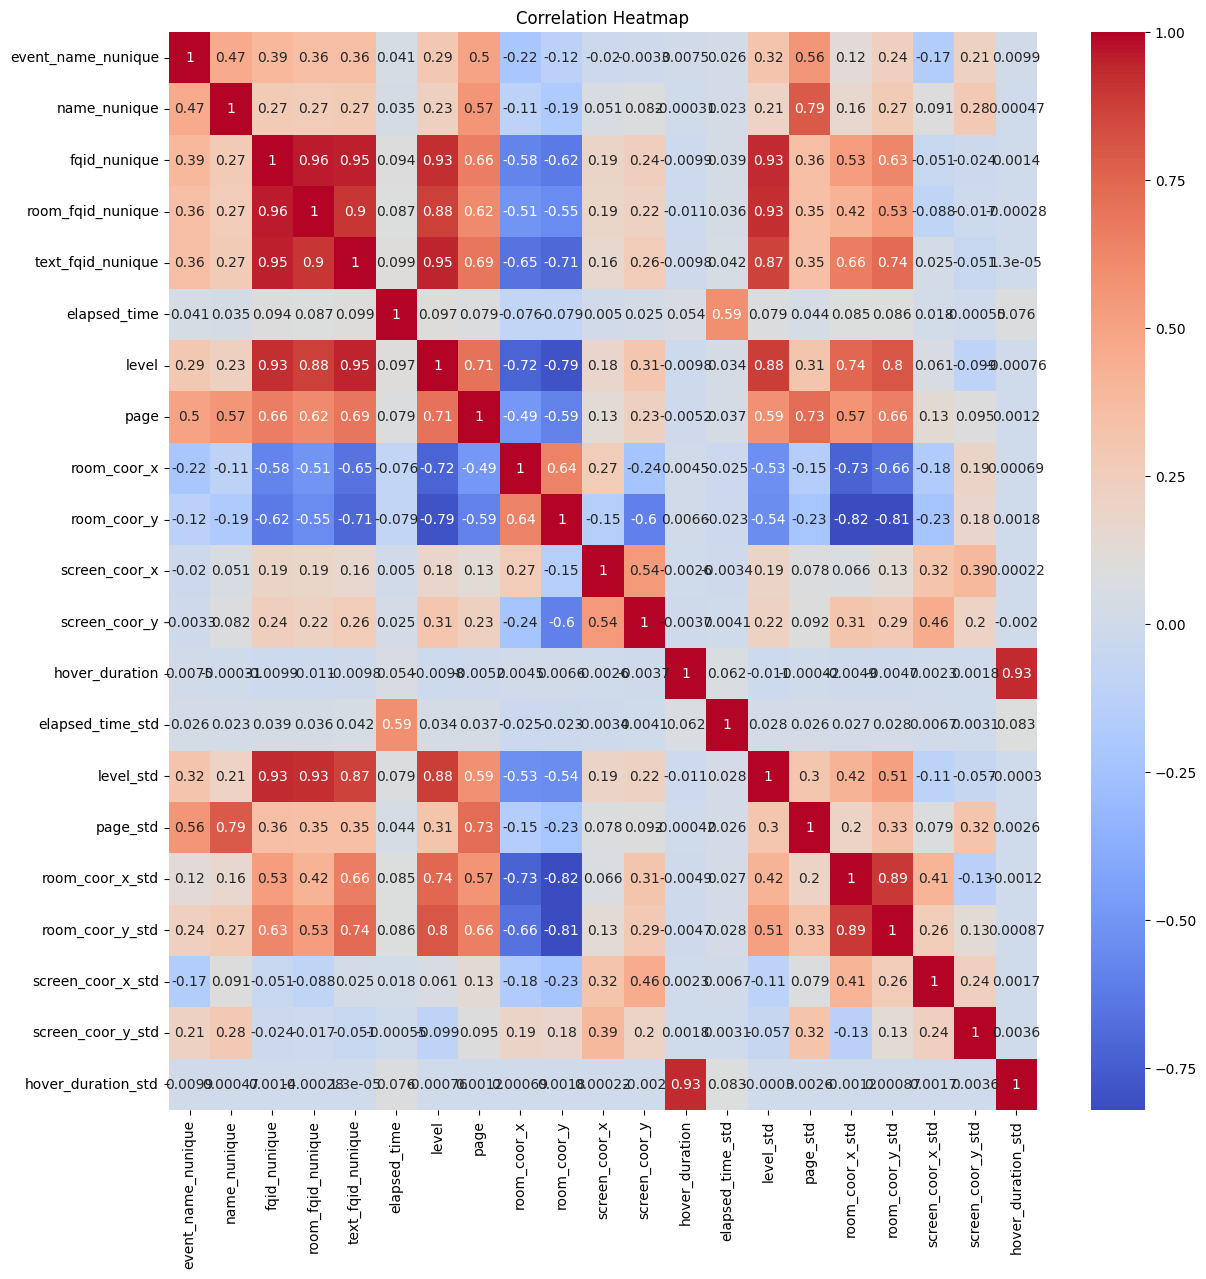

In [66]:
# Calculate the correlation matrix
corr = dataset_df.corr()

# Plotting the heatmap
plt.figure(figsize=(14, 14))
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        annot=True,
        cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

#### Analysing Features and their relationships

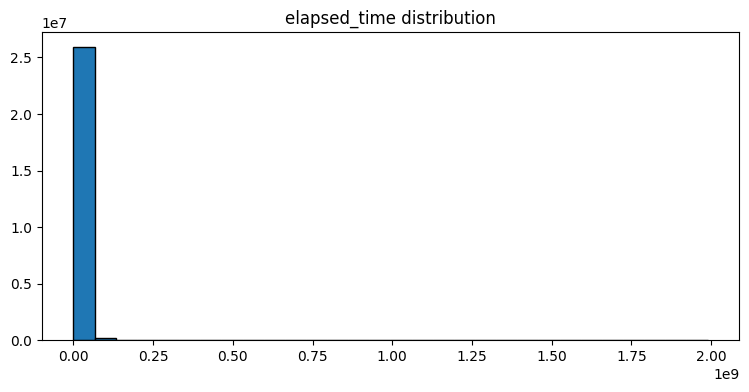

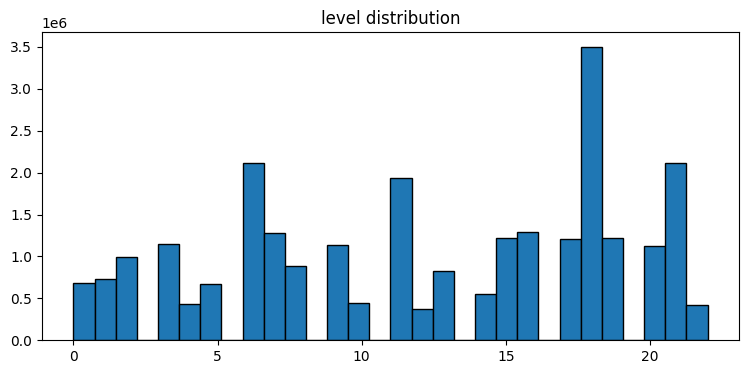

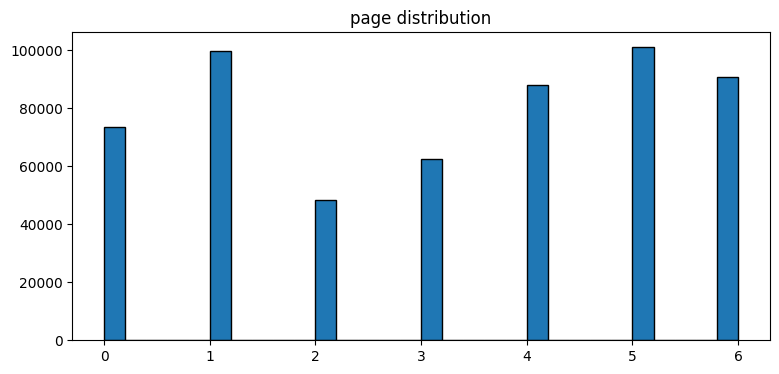

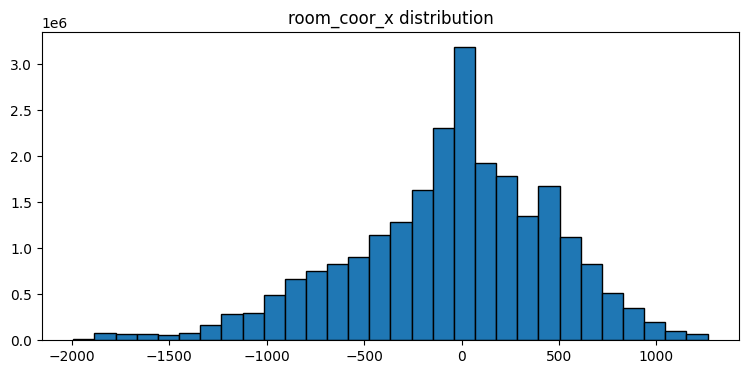

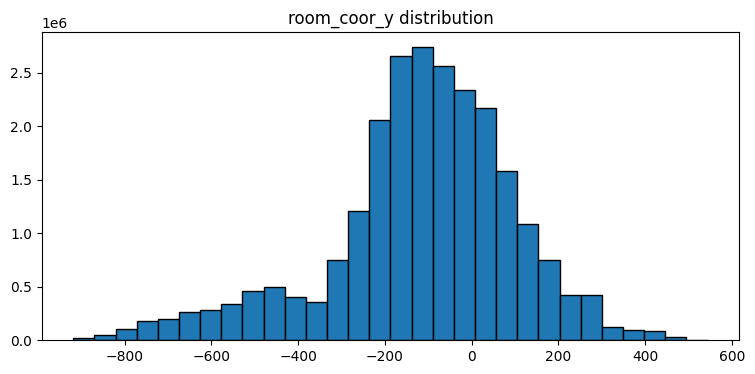

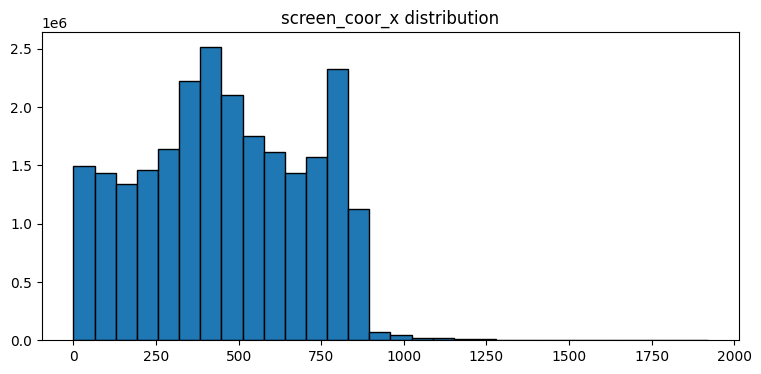

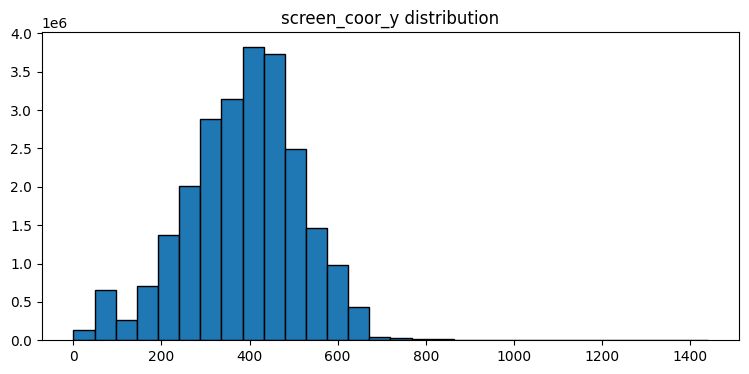

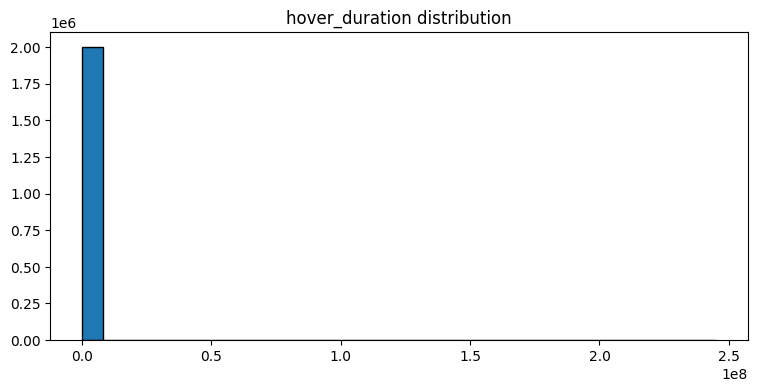

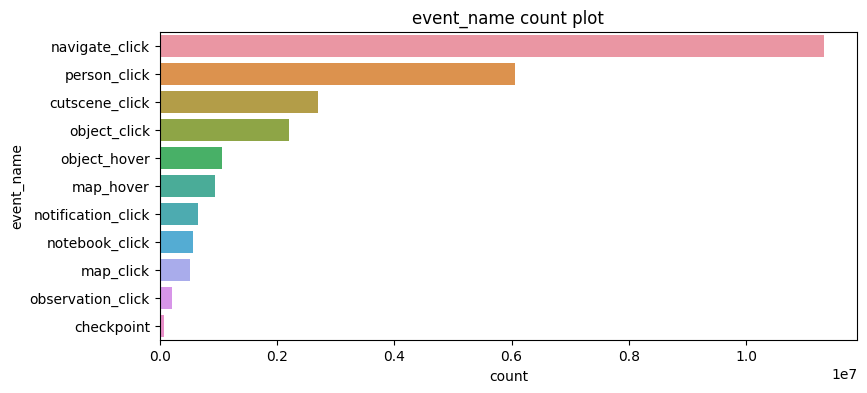

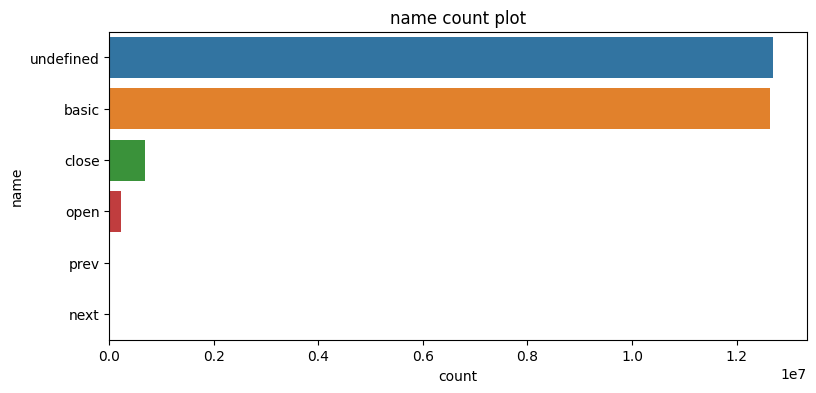

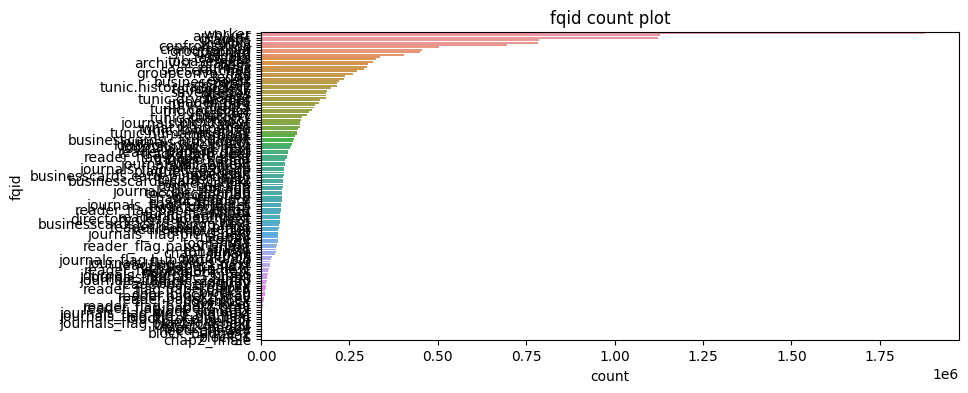

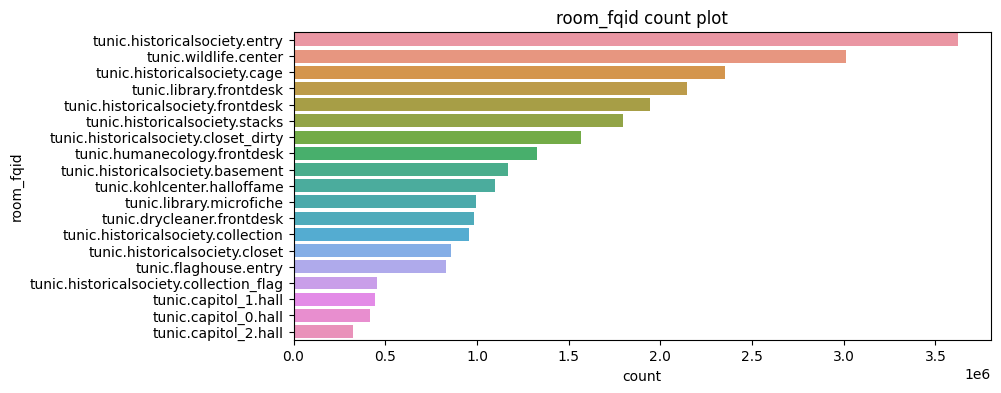

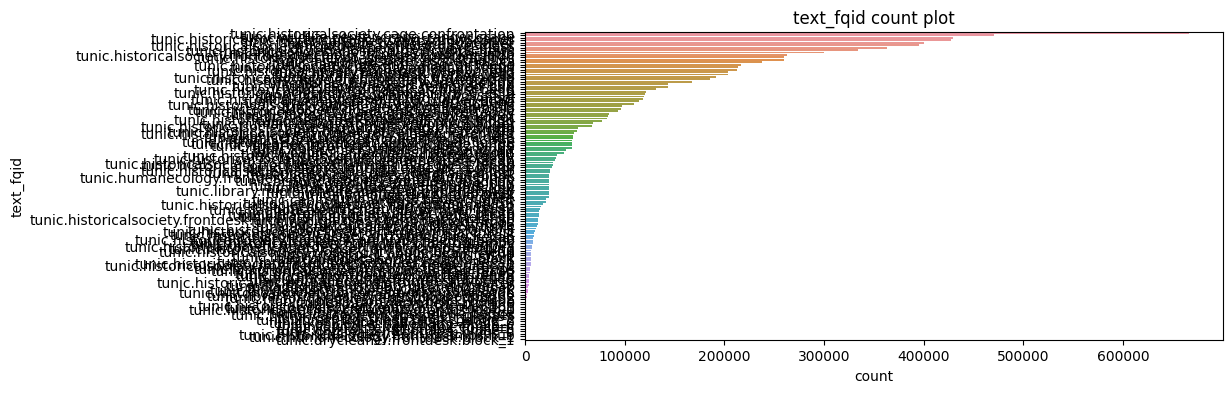

In [78]:
CATEGORICAL = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
NUMERICAL = ['elapsed_time','level','page','room_coor_x', 'room_coor_y',
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# Iterate over numerical features and plot histogram
for feature in NUMERICAL:
    plt.figure(figsize=(9, 4))
    plt.hist(dataset_df[feature].dropna(), bins=30, edgecolor='black')
    plt.title(f'{feature} distribution')
    plt.show()

# Iterate over categorical features and plot bar chart
for feature in CATEGORICAL:
    plt.figure(figsize=(9, 4))
    sns.countplot(data=dataset_df, y=feature, order = dataset_df[feature].value_counts().index)
    plt.title(f'{feature} count plot')
    plt.show()


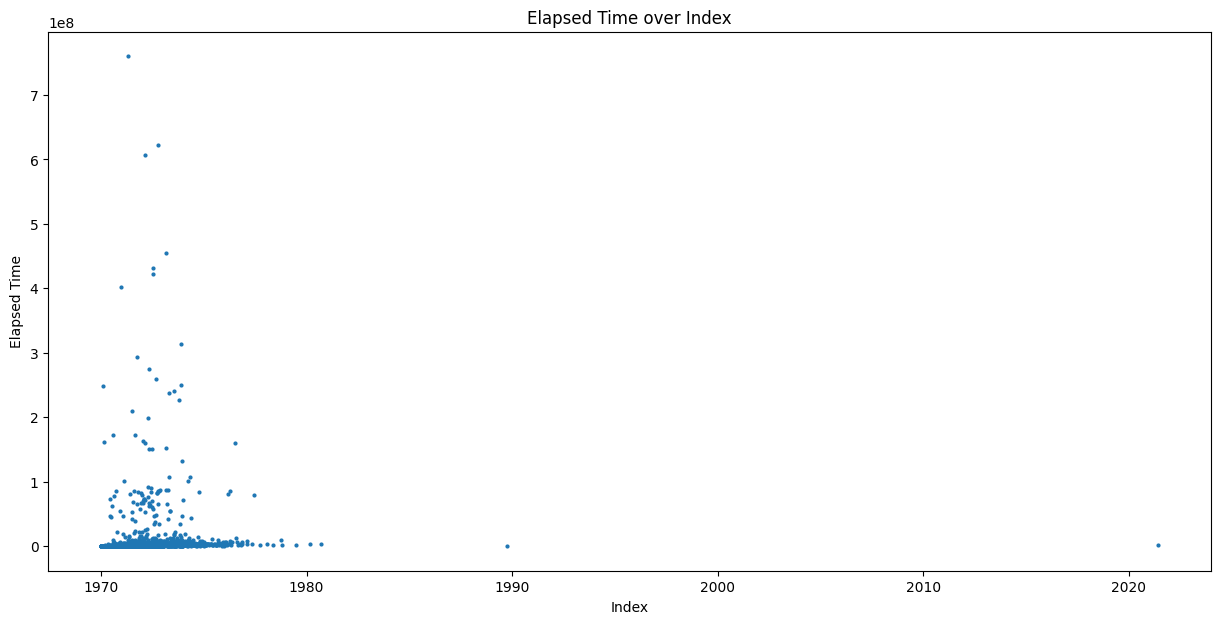

In [79]:
# Temporal Analysis: Look into trend of certain variables overtime
# Plotting elapsed_time over index could give an idea about time trends.
# We'll take a sample of the data for visual clarity

sample_data = dataset_df.sample(5000)

plt.figure(figsize=(15, 7))
plt.plot_date(sample_data['index'], sample_data['elapsed_time'], markersize=2)
plt.title('Elapsed Time over Index')
plt.xlabel('Index')
plt.ylabel('Elapsed Time')
plt.show()


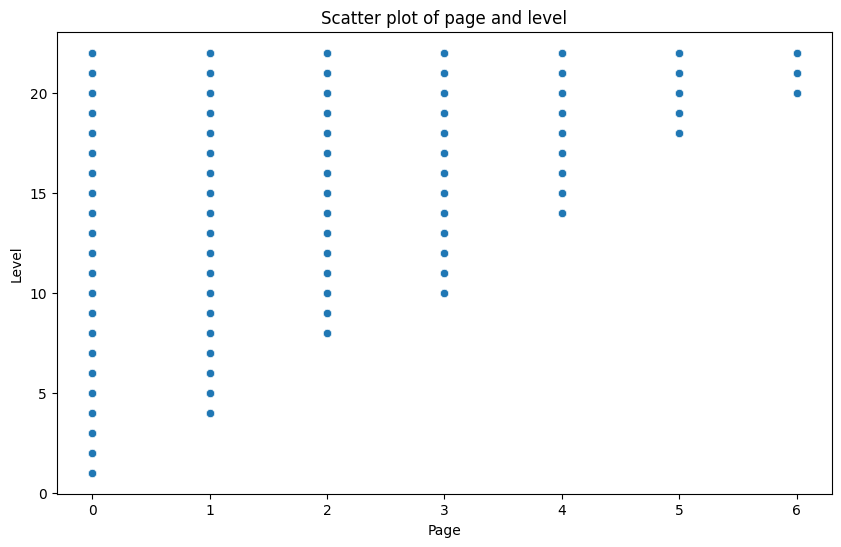

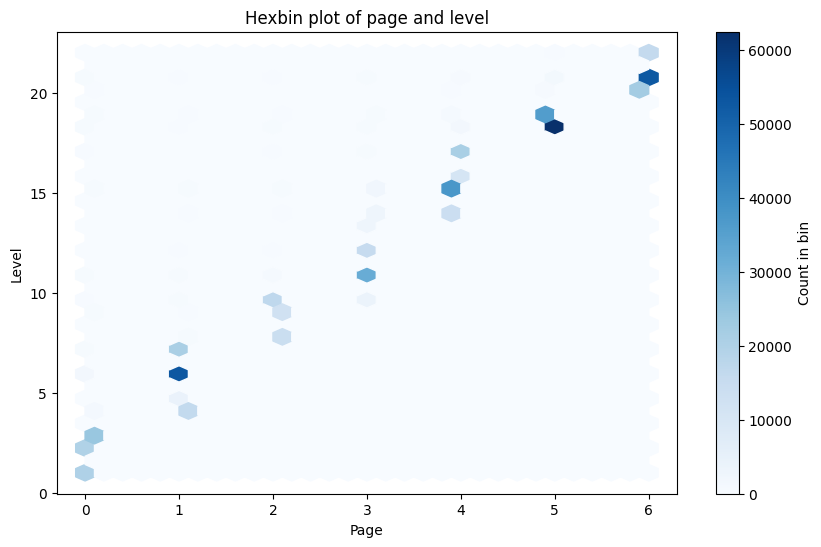

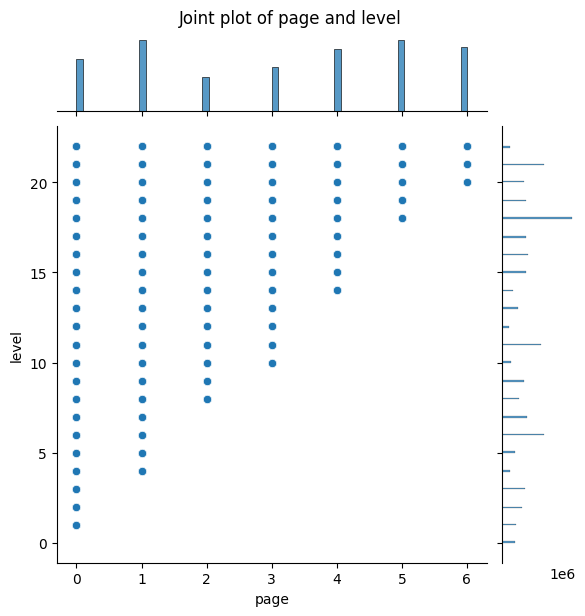

In [31]:
# Scatter plot of 'page' & 'level'
plt.figure(figsize=(10,6))
sns.scatterplot(data=dataset_df, x='page', y='level')
plt.title('Scatter plot of page and level')
plt.xlabel('Page')
plt.ylabel('Level')
plt.show()

# Hexbin plot
plt.figure(figsize=(10,6))
plt.hexbin(data=dataset_df, x='page', y='level', gridsize=30, cmap='Blues')
plt.colorbar(label='Count in bin')
plt.title('Hexbin plot of page and level')
plt.xlabel('Page')
plt.ylabel('Level')
plt.show()

sns.jointplot(data=dataset_df, x='page', y='level', kind='scatter')
plt.suptitle('Joint plot of page and level', y=1.02)
plt.show()

In [28]:
# Install the plotly library
!pip install plotly
import plotly.express as px

# Visualizing player's click coordinates in the game room. We'll again take a sample for visual clarity.
sample_data = dataset_df.sample(1000)

fig = px.scatter(sample_data, x='room_coor_x', y='room_coor_y', color='event_name',
                 title='Player Click Coordinates in Game Room')
fig.show()


Feature Engineering

In [80]:
"""def feature_engineer(dataset_df):
    dfs = []
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in NUMERICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df"""

def feature_engineer(dataset_df):
    dfs = []

    # count the number of unique elements for categorical columns
    for c in CATEGORICAL:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].nunique()
        tmp.name = c + '_nunique'
        dfs.append(tmp)

    # calculate mean, std, min, max for numerical columns
    for c in NUMERICAL:
        tmp_mean = dataset_df.groupby(['session_id','level_group'])[c].mean()
        tmp_mean.name = c + '_mean'
        dfs.append(tmp_mean)

        tmp_std = dataset_df.groupby(['session_id','level_group'])[c].std()
        tmp_std.name = c + '_std'
        dfs.append(tmp_std)

        tmp_min = dataset_df.groupby(['session_id','level_group'])[c].min()
        tmp_min.name = c + '_min'
        dfs.append(tmp_min)

        tmp_max = dataset_df.groupby(['session_id','level_group'])[c].max()
        tmp_max.name = c + '_max'
        dfs.append(tmp_max)

    # combine all features into one dataframe
    dataset_df = pd.concat(dfs, axis=1)

    # replace missing values with -1
    dataset_df = dataset_df.fillna(-1)

    # reset index
    dataset_df = dataset_df.reset_index()

    # set index to be the session id
    dataset_df = dataset_df.set_index('session_id')

    return dataset_df


In [87]:
dataset_df = feature_engineer(dataset_df)
print("Full prepared dataset shape is {}".format(dataset_df.shape))

KeyError: ignored

### Decision forest code

In [82]:
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = dataset.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))

56547 examples in training, 14139 examples in testing.


In [83]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [84]:
# Fetch the unique list of user sessions in the validation dataset. We assigned
# `session_id` as the index of our feature engineered dataset. Hence fetching
# the unique values in the index column will give us a list of users in the
# validation set.
VALID_USER_LIST = valid_x.index.unique()

# Create a dataframe for storing the predictions of each question for all users
# in the validation set.
# For this, the required size of the data frame is:
# (no: of users in validation set  x no of questions).
# We will initialize all the predicted values in the data frame to zero.
# The dataframe's index column is the user `session_id`s.
prediction_df = pd.DataFrame(data=np.zeros((len(VALID_USER_LIST),18)), index=VALID_USER_LIST)

# Create an empty dictionary to store the models created for each question.
models = {}

# Create an empty dictionary to store the evaluation score for each question.
evaluation_dict ={}

In [86]:

for q_no in range(1,19):

    # Select level group for the question based on the q_no.
    if q_no<=3: grp = '0-4'
    elif q_no<=13: grp = '5-12'
    elif q_no<=22: grp = '13-22'
    print("### q_no", q_no, "grp", grp)


    # Filter the rows in the datasets based on the selected level group.
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values

    # Select the labels for the related q_no.
    train_labels = labels.loc[labels.q==q_no].set_index('session').loc[train_users]
    valid_labels = labels.loc[labels.q==q_no].set_index('session').loc[valid_users]


    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]

    # There's one more step required before we can train the model.
    # We need to convert the datatset from Pandas format (pd.DataFrame)
    # into TensorFlow Datasets format (tf.data.Dataset).
    # TensorFlow Datasets is a high performance data loading library
    # which is helpful when training neural networks with accelerators like GPUs and TPUs.
    # We are omitting `level_group`, since it is not needed for training anymore.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df.loc[:, train_df.columns != 'level_group'], label="correct")
    valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df.loc[:, valid_df.columns != 'level_group'], label="correct")

    # We will now create the Gradient Boosted Trees Model with default settings.
    # By default the model is set to train for a classification task.
    gbtm = tfdf.keras.RandomForestModel(verbose=0)
    gbtm.compile(metrics=["accuracy"])

    # Train the model.
    gbtm.fit(x=train_ds)

    # Store the model
    models[f'{grp}_{q_no}'] = gbtm

    # Evaluate the trained model on the validation dataset and store the
    # evaluation accuracy in the `evaluation_dict`.
    inspector = gbtm.make_inspector()
    inspector.evaluation()
    evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)
    evaluation_dict[q_no] = evaluation["accuracy"]

    # Use the trained model to make predictions on the validation dataset and
    # store the predicted values in the `prediction_df` dataframe.
    predict = gbtm.predict(x=valid_ds)
    prediction_df.loc[valid_users, q_no-1] = predict.flatten()

<ipython-input-86-3dd99c1b5502>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-3dd99c1b5502>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-3dd99c1b5502>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-86-3dd99c

### q_no 1 grp 0-4


ValueError: ignored